In [ ]:
# import os, pathlib
# os.chdir(pathlib.Path.cwd().parent)
# fix import of local files

In [ ]:
# pathlib.Path.cwd()

WindowsPath('d:/Coding/Neural_Networks_Project')

In [4]:
from __future__ import annotations

from pathlib import Path
import random
import sys

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from src.data_pipeline import random_test_patches_mask
from src.utils import plot_true_vs_pred


In [ ]:

# ─────────────────────────────────────────────────────────────────── parameters ──
SEED: int = 42
N_JOBS: int = -1
SUB_FRAC: float = 0.40  # down‑sample training set to keep RAM reasonable

DATA_DIR = Path("data/processed")

DATASETS: dict[str, str] = {
    "nitrate_00": "nitrate_00_train_data.parquet",
    "oxygen_00": "oxygen_00_train_data.parquet",
    "phosphate_00": "phosphate_00_train_data.parquet",
}

FEATURES: list[str] = [
    "temperature_00",
    "salinity_00",
    "sin_lat",
    "cos_lat",
    "sin_lon",
    "cos_lon",
    "norm_depth",
]

RF_PARAMS: dict = {
    "n_estimators": 400,
    "n_jobs": -1,
    "random_state": SEED,
}

XGB_PARAMS: dict = {
    "n_estimators": 600,
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "reg_lambda": 1.0,
    "device": "cuda",  # switch to "cpu" if no GPU is available
    "n_jobs": N_JOBS,
    "random_state": SEED,
}

PLOT_KW = dict(figsize=(16, 9))



In [6]:

# ─────────────────────────────────────────────────────────────────── utilities ──

def evaluate(name: str, y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:10.4f}  RMSE={rmse:9.4f}  MAE={mae:9.4f}  R2={r2:7.4f}")
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


def add_geo_features(df: pd.DataFrame) -> pd.DataFrame:
    """Append sin/cos(lat,lon) and normalised depth in‑place and return *view*."""
    deg2rad = np.pi / 180.0
    df["sin_lat"] = np.sin(df["lat"] * deg2rad)
    df["cos_lat"] = np.cos(df["lat"] * deg2rad)
    df["sin_lon"] = np.sin(df["lon"] * deg2rad)
    df["cos_lon"] = np.cos(df["lon"] * deg2rad)
    df["norm_depth"] = df["depth"] / df["depth"].max()
    return df


Training baseline models for: nitrate_00
Cleaned data shape: (650396, 13)
Train samples: 202,379
Test  samples: 144,448
RandomForest       MSE=   27.7492  RMSE=   5.2677  MAE=   2.9925  R2= 0.8812
XGBoost            MSE=   16.9062  RMSE=   4.1117  MAE=   2.7437  R2= 0.9276
Linear interp 3D   MSE=   26.8042  RMSE=   5.1773  MAE=   3.5027  R2= 0.8852


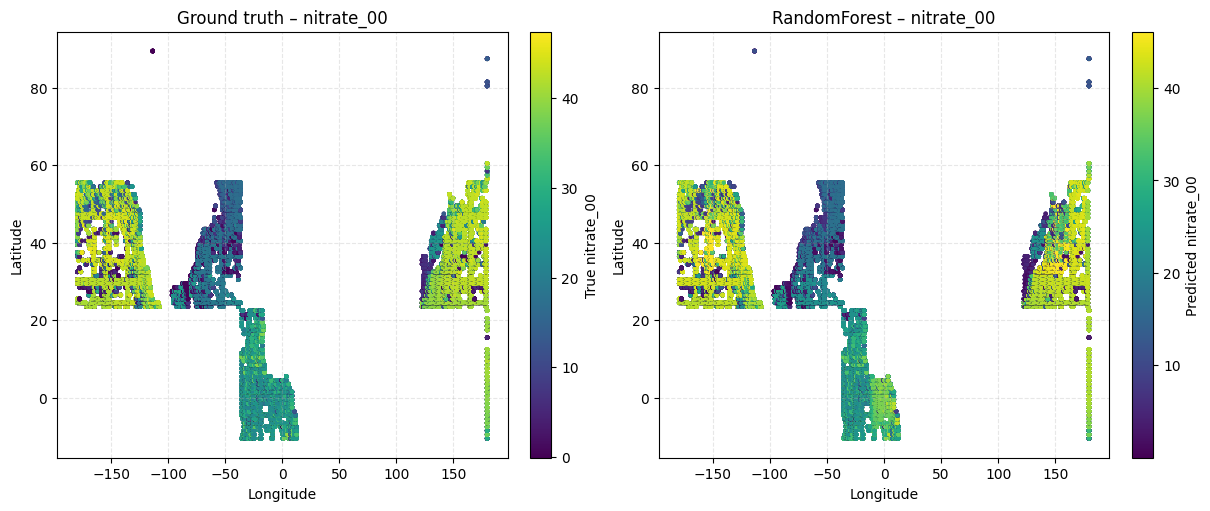


Training baseline models for: oxygen_00
Cleaned data shape: (1499394, 13)
Train samples: 497,089
Test  samples: 256,671
RandomForest       MSE=  990.5760  RMSE=  31.4734  MAE=  19.5836  R2= 0.8151
XGBoost            MSE=  859.7703  RMSE=  29.3218  MAE=  20.2437  R2= 0.8395
Linear interp 3D   MSE= 1485.6467  RMSE=  38.5441  MAE=  24.8647  R2= 0.7227


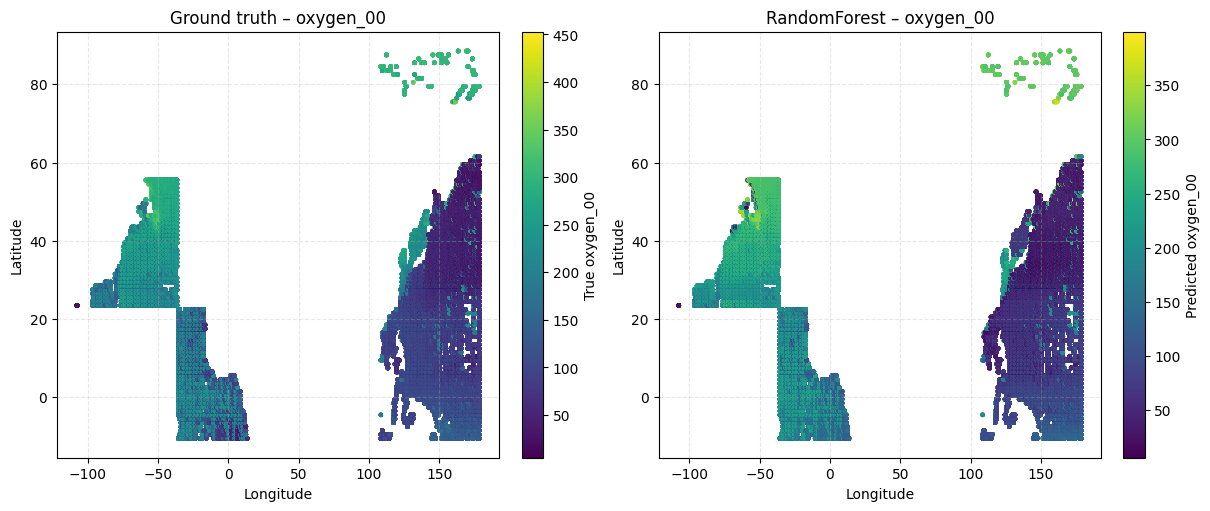


Training baseline models for: phosphate_00
Cleaned data shape: (847439, 13)
Train samples: 267,099
Test  samples: 179,691
RandomForest       MSE=    0.0778  RMSE=   0.2789  MAE=   0.1829  R2= 0.9283
XGBoost            MSE=    0.0834  RMSE=   0.2888  MAE=   0.2039  R2= 0.9231
Linear interp 3D   MSE=    0.1289  RMSE=   0.3590  MAE=   0.2540  R2= 0.8811


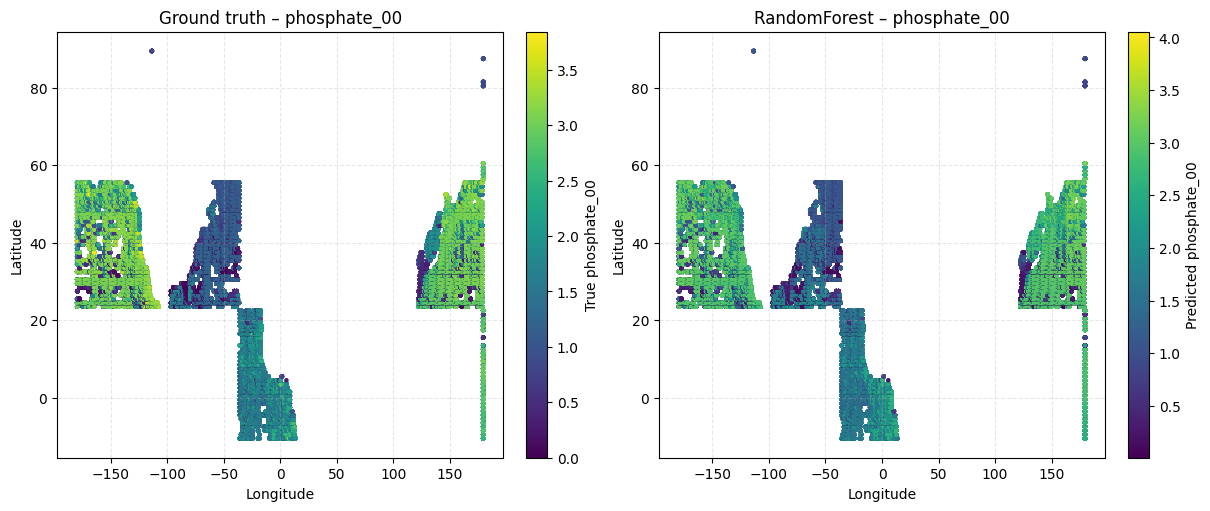

In [8]:

# ─────────────────────────────────────────────────────────────────── main loop ──

random.seed(SEED)
np.random.seed(SEED)

summary_records: list[dict] = []

for target, fname in DATASETS.items():
    print("\n" + "=" * 20)
    print(f"Training baseline models for: {target}")
    print("=" * 20)

    df = pd.read_parquet(DATA_DIR / fname)
    df = add_geo_features(df)

    cols_to_keep = FEATURES + [target]
    df = df.dropna(subset=cols_to_keep).reset_index(drop=True)
    print(f"Cleaned data shape: {df.shape}")

    test_mask = random_test_patches_mask(
        df,
        grid_size=(5, 5),
        n_patches=5,
        seed=SEED + 123,  # deterministic – but different from generate
    )
    train_df = df.loc[~test_mask].reset_index(drop=True)
    test_df = df.loc[test_mask].reset_index(drop=True)
    train_df = train_df.sample(frac=SUB_FRAC, random_state=SEED).reset_index(drop=True)

    print(f"Train samples: {len(train_df):,d}")
    print(f"Test  samples: {len(test_df):,d}")

    # ── numpy arrays + scaling ──
    X_train = train_df[FEATURES].values
    y_train = train_df[target].values
    X_test = test_df[FEATURES].values
    y_test = test_df[target].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # ─────────────────────────── Random Forest ───────────────────────────
    rf = make_pipeline(SimpleImputer(strategy="median"), RandomForestRegressor(**RF_PARAMS))
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    metrics_rf = evaluate("RandomForest", y_test, pred_rf)

    # ───────────────────────────── XGBoost ───────────────────────────────
    xgb = XGBRegressor(**XGB_PARAMS)
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)
    metrics_xgb = evaluate("XGBoost", y_test, pred_xgb)

    # ─────── 3‑D linear interpolation baseline (lat,lon,depth) ──────────
    train_pts = train_df[["lat", "lon", "depth"]].values
    test_pts = test_df[["lat", "lon", "depth"]].values
    pred_lin = griddata(train_pts, y_train, test_pts, method="linear")
    # fallback to nearest neighbour where linear is NaN
    nan_mask = np.isnan(pred_lin)
    if nan_mask.any():
        pred_nn = griddata(train_pts, y_train, test_pts[nan_mask], method="nearest")
        pred_lin[nan_mask] = pred_nn
    metrics_lin = evaluate("Linear interp 3D", y_test, pred_lin)

    # ─────────────────────────── GEO plots (optional) ────────────────────
    plot_true_vs_pred(test_df, y_test, pred_rf, target=target)

    # accumulate summary metrics
    summary_records.append({
        "target": target,
        **{f"rf_{k}": v for k, v in metrics_rf.items()},
        **{f"xgb_{k}": v for k, v in metrics_xgb.items()},
        **{f"lin_{k}": v for k, v in metrics_lin.items()},
    })
